<a href="https://colab.research.google.com/github/poandpo/final_project/blob/main/AI_06_%EC%9E%84%EC%B1%84%EC%9D%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 모듈

In [1]:
!pip install sentence_transformers
!pip install mxnet
!pip install transformers==3 
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

     |████████████████████████████████| 78 kB 4.5 MB/s 
     |████████████████████████████████| 3.5 MB 16.7 MB/s 
     |████████████████████████████████| 6.8 MB 31.9 MB/s 
     |████████████████████████████████| 1.2 MB 51.7 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 51.2 MB/s 
     |████████████████████████████████| 895 kB 55.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=71d0554916a8ec06969bdb86d5d59928dba25d11cf691042e9015fcd23632c40
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 47.3 MB 17.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installat

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
from numpy import dot
from numpy.linalg import norm
import urllib.request
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 불러오기 & 확인

깃헙에서 올린 파일 가져올때는 public으로 해놔야 가져옴 아니면 HTTPError 404 오류 뜸

In [3]:
path1 = 'https://raw.githubusercontent.com/poandpo/project-4/main/%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94%EB%A7%90%EB%AD%89%EC%B9%98(%EC%B5%9C%EC%A2%85%EB%8D%B0%EC%9D%B4%ED%84%B0)_Training.csv'
path2 = 'https://raw.githubusercontent.com/poandpo/project-4/main/%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94%EB%A7%90%EB%AD%89%EC%B9%98_Validation.csv'
path3 = 'https://raw.githubusercontent.com/poandpo/final_project/main/%EC%9B%B0%EB%8B%88%EC%8A%A4_%EB%8C%80%ED%99%94_%EC%8A%A4%ED%81%AC%EB%A6%BD%ED%8A%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B(%EB%B3%84).csv'
data_1 = pd.read_csv(path1, delimiter= ',')
data_2 = pd.read_csv(path2, delimiter= ',')
data_3 = pd.read_csv(path3, delimiter= ',')

In [ ]:
data_1.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [ ]:
data_1.shape, data_2.shape

((40879, 15), (5130, 15))

In [ ]:
print(data_3.shape)
data_3.head() # 특이사항, 추가발화 2개 삭제 

(5231, 4)


,구분,유저,챗봇,Unnamed: 3
0,감정/감정조절이상,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,NaN
1,감정/감정조절이상,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?,NaN
2,감정/감정조절이상,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.",NaN
3,감정/감정조절이상,꼭 롤러코스터 타는 것 같아요.,NaN,NaN
4,감정/감정조절이상,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.,NaN,NaN


In [ ]:
data_1.isnull().sum()

번호            0
연령            0
성별            0
상황키워드         0
신체질환          0
감정_대분류        0
감정_소분류        0
사람문장1         0
시스템응답1        0
사람문장2         0
시스템응답2        0
사람문장3      9820
시스템응답3     9820
사람문장4     39407
시스템응답4    39517
dtype: int64

In [ ]:
data_2.isnull().sum()

번호           0
연령           0
성별           0
상황키워드        0
신체질환         0
감정_대분류       0
감정_소분류       0
사람문장1        0
시스템응답1       0
사람문장2        0
시스템응답2       0
사람문장3     1256
시스템응답3    1256
사람문장4     4979
시스템응답4    4994
dtype: int64

# 데이터 합치기

In [4]:
df_1 = data_1[['감정_대분류','감정_소분류','사람문장1', '시스템응답1']]
df_2 = data_2[['감정_대분류','감정_소분류','사람문장1', '시스템응답1']]
half_df = pd.concat([df_1,df_2])

In [5]:
half_df['감정_대분류'].unique()

array(['기쁨', '불안', '당황', '슬픔', '분노', '상처', '불안 ', '기쁨 '], dtype=object)

In [5]:
# data_3에 맞게 수정
half_df.loc[ half_df['감정_대분류'] == '기쁨','감정_대분류'] = '즐거움'
half_df.loc[ half_df['감정_대분류'] == '기쁨 ', '감정_대분류'] = '즐거움'
half_df.loc[ half_df['감정_대분류'] == '불안', '감정_대분류'] = '불안감'
half_df.loc[ half_df['감정_대분류'] == '불안 ', '감정_대분류'] = '불안감'
## half_df['감정_대분류'] == '상처' --> 수정
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '억울한'), '감정_대분류'] = '억울함'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '배신당한'), '감정_대분류'] = '배신감'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '괴로워하는'), '감정_대분류'] = '괴로움'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '충격 받은'), '감정_대분류'] = '충격'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '버려진'), '감정_대분류'] = '고독감'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '고립된'), '감정_대분류'] = '외로움'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '질투하는'), '감정_대분류'] = '질투'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '가난한, 불우한'), '감정_대분류'] = '배경/경제적문제/가난'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '조심스러운'), '감정_대분류'] = '모호함'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '상처'), '감정_대분류'] = '속상함'
half_df.loc[(half_df['감정_대분류'] == '상처') & (half_df['감정_소분류']== '희생된'), '감정_대분류'] = '속상함'
half_df.drop(labels= '감정_소분류', axis= 1, inplace= True)
## '감정/' 더하기
half_df['감정_대분류'] = '감정/'+ half_df['감정_대분류']
half_df.loc[ half_df['감정_대분류'] == '감정/배경/경제적문제/가난', '감정_대분류'] = '배경/경제적문제/가난'

#데이터 합치기
data_3.drop(labels= 'Unnamed: 3', axis= 1, inplace= True )
half_df.columns = ['구분', '유저', '챗봇']
df = pd.concat([half_df,data_3])
## 인텍스 정렬
df = df.reset_index(drop=True)


In [ ]:
print(df.shape)
df.head(5)

(51240, 3)


,구분,유저,챗봇
0,감정/즐거움,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.
1,감정/불안감,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.
2,감정/당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.
3,감정/즐거움,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.
4,감정/즐거움,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?


# 전처리 과정

In [6]:
#중복확인
df.duplicated().sum(), data_3.duplicated().sum()

(1282, 16)

In [6]:
#중복 제거
df.drop_duplicates(inplace= True)

In [8]:
# 결측치 확인
df['챗봇'].isnull().sum()

4181

In [7]:
# 결측치 제거
df=df.dropna()

In [7]:
#결측지 제거 확인
df['챗봇'].isnull().sum()

4181

In [8]:
#labelencoder로 구분 컬럼 정수로 바꾸기
np.random.seed(3)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
enc = le.fit_transform(df['구분'])
df['구분'] = enc

## 트랜스포머를 위한 데이터 전처리

In [8]:
questions = []
for sentence in df['유저']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [9]:
answers = []
for sentence in df['챗봇']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    try: 
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        answers.append(sentence)
    except TypeError as e:
        pass

In [10]:
# 단어 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [11]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [12]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8276]
종료 토큰 번호 : [8277]
단어 집합의 크기 : 8278


In [13]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5407, 1975, 1938, 1469, 19, 4, 197, 3683, 1232, 2, 37, 91, 4617, 6480, 3234, 3044, 6, 34, 1]
기존 문장: 지난주에 주식이 폭락해서 너무 큰 손해를 봤어 .  어떻게 해야 좋을지 모르겠고 정신이 나갈 것 같아 .


In [14]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5407 ----> 지난주에 
1975 ----> 주식이 
1938 ----> 폭
1469 ----> 락
19 ----> 해서 
4 ----> 너무 
197 ----> 큰 
3683 ----> 손해를 
1232 ----> 봤어
2 ---->  .  
37 ----> 어떻게 
91 ----> 해야 
4617 ----> 좋을지 
6480 ----> 모르겠고 
3234 ----> 정신이 
3044 ----> 나갈 
6 ----> 것 
34 ----> 같아
1 ---->  .


In [15]:

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [16]:
MAX_LENGTH = 20

In [18]:
MAX_LENGTH = 40

In [16]:
MAX_LENGTH = 60

In [17]:
questions, answers = tokenize_and_filter(questions, answers)

In [18]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (45777, 20)
답변 데이터의 크기(shape) : (45777, 20)


In [19]:
questions[20]

array([5407, 1975, 1938, 1469,   19,    4,  197, 3683, 1232,    2,   37,
         91, 4617, 6480, 3234, 3044,    6,   34,    1, 8277], dtype=int32)

# 모델 구현

## transformer 구현- 다시 복습

In [20]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model) 

  def get_config(self):
        config = super().get_config().copy()
        return config  

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [21]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [23]:
def scaled_dot_product_attention(query, key, value, mask):

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  def get_config(self):
        config = super().get_config().copy()
        return config  


  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [25]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [26]:
#num_layer개 만큼 인코더 쌓고 마지막층에 행렬을 디코더로 보내주는 코드
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [27]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [28]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [29]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [30]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,

     }
    return config
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## transformer 챗봇 

In [42]:
BATCH_SIZE = 32

In [32]:
BATCH_SIZE = 64

In [38]:
BATCH_SIZE = 128

In [33]:
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [34]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 24.4 GB  |     Proc size: 2.6 GB
GPU RAM Free: 15903MB | Used: 377MB | Util   2% | Total     16280MB


In [35]:
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8278, 256)
(1, 8278, 256)


In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [40]:
# batch_size = 32   Max_len = 20
EPOCHS = 10 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
1431/1431 [==============================] - 55s 33ms/step - loss: 3.6086 - accuracy: 0.1143
Epoch 2/10
1431/1431 [==============================] - 43s 30ms/step - loss: 2.6164 - accuracy: 0.1781
Epoch 3/10
1431/1431 [==============================] - 44s 30ms/step - loss: 2.3027 - accuracy: 0.1982
Epoch 4/10
1431/1431 [==============================] - 43s 30ms/step - loss: 2.0799 - accuracy: 0.2137
Epoch 5/10
1431/1431 [==============================] - 42s 30ms/step - loss: 1.8867 - accuracy: 0.2296
Epoch 6/10
1431/1431 [==============================] - 42s 29ms/step - loss: 1.7329 - accuracy: 0.2447
Epoch 7/10
1431/1431 [==============================] - 42s 29ms/step - loss: 1.6081 - accuracy: 0.2597
Epoch 8/10
1431/1431 [==============================] - 42s 29ms/step - loss: 1.4983 - accuracy: 0.2737
Epoch 9/10
1431/1431 [==============================] - 42s 29ms/step - loss: 1.4046 - accuracy: 0.2866
Epoch 10/10
1431/1431 [==============================] - 42s 30m

In [47]:
# batch_size = 32   Max_len = 40
EPOCHS = 10 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
1431/1431 [==============================] - 71s 45ms/step - loss: 1.7730 - accuracy: 0.0551
Epoch 2/10
1431/1431 [==============================] - 63s 44ms/step - loss: 1.2889 - accuracy: 0.0861
Epoch 3/10
1431/1431 [==============================] - 62s 44ms/step - loss: 1.1285 - accuracy: 0.0965
Epoch 4/10
1431/1431 [==============================] - 60s 42ms/step - loss: 1.0161 - accuracy: 0.1043
Epoch 5/10
1431/1431 [==============================] - 60s 42ms/step - loss: 0.9187 - accuracy: 0.1123
Epoch 6/10
1431/1431 [==============================] - 61s 42ms/step - loss: 0.8417 - accuracy: 0.1200
Epoch 7/10
1431/1431 [==============================] - 61s 43ms/step - loss: 0.7788 - accuracy: 0.1275
Epoch 8/10
1431/1431 [==============================] - 61s 43ms/step - loss: 0.7241 - accuracy: 0.1349
Epoch 9/10
1431/1431 [==============================] - 61s 43ms/step - loss: 0.6772 - accuracy: 0.1417
Epoch 10/10
1431/1431 [==============================] - 61s 43m

In [41]:
# batch_size = 32   Max_len = 60
EPOCHS = 50 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
1431/1431 [==============================] - 82s 51ms/step - loss: 1.1697 - accuracy: 0.0370
Epoch 2/50
1431/1431 [==============================] - 70s 49ms/step - loss: 0.8535 - accuracy: 0.0568
Epoch 3/50
1431/1431 [==============================] - 69s 48ms/step - loss: 0.7495 - accuracy: 0.0635
Epoch 4/50
1431/1431 [==============================] - 71s 49ms/step - loss: 0.6743 - accuracy: 0.0686
Epoch 5/50
1431/1431 [==============================] - 74s 52ms/step - loss: 0.6101 - accuracy: 0.0739
Epoch 6/50
1431/1431 [==============================] - 68s 48ms/step - loss: 0.5587 - accuracy: 0.0791
Epoch 7/50
1431/1431 [==============================] - 69s 48ms/step - loss: 0.5177 - accuracy: 0.0839
Epoch 8/50
1431/1431 [==============================] - 68s 48ms/step - loss: 0.4822 - accuracy: 0.0886
Epoch 9/50
1431/1431 [==============================] - 68s 48ms/step - loss: 0.4519 - accuracy: 0.0930
Epoch 10/50
1431/1431 [==============================] - 70s 49m

In [48]:
# batch_size = 64   Max_len = 20
EPOCHS = 10 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
716/716 [==============================] - 37s 43ms/step - loss: 4.0484 - accuracy: 0.0862
Epoch 2/10
716/716 [==============================] - 31s 43ms/step - loss: 2.9273 - accuracy: 0.1583
Epoch 3/10
716/716 [==============================] - 31s 43ms/step - loss: 2.4625 - accuracy: 0.1888
Epoch 4/10
716/716 [==============================] - 31s 43ms/step - loss: 2.1351 - accuracy: 0.2110
Epoch 5/10
716/716 [==============================] - 31s 43ms/step - loss: 1.8979 - accuracy: 0.2273
Epoch 6/10
716/716 [==============================] - 30s 42ms/step - loss: 1.7249 - accuracy: 0.2421
Epoch 7/10
716/716 [==============================] - 30s 42ms/step - loss: 1.5318 - accuracy: 0.2628
Epoch 8/10
716/716 [==============================] - 30s 42ms/step - loss: 1.3417 - accuracy: 0.2871
Epoch 9/10
716/716 [==============================] - 30s 42ms/step - loss: 1.1791 - accuracy: 0.3105
Epoch 10/10
716/716 [==============================] - 30s 42ms/step - loss: 1.036

In [ ]:
# batch_size = 64 Max_len = 40
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
716/716 [==============================] - 48s 57ms/step - loss: 1.9847 - accuracy: 0.0419
Epoch 2/50
716/716 [==============================] - 41s 57ms/step - loss: 1.4429 - accuracy: 0.0762
Epoch 3/50
716/716 [==============================] - 41s 57ms/step - loss: 1.2181 - accuracy: 0.0908
Epoch 4/50
716/716 [==============================] - 41s 57ms/step - loss: 1.0525 - accuracy: 0.1021
Epoch 5/50
716/716 [==============================] - 41s 57ms/step - loss: 0.9311 - accuracy: 0.1106
Epoch 6/50
716/716 [==============================] - 41s 57ms/step - loss: 0.8418 - accuracy: 0.1183
Epoch 7/50
716/716 [==============================] - 41s 57ms/step - loss: 0.7424 - accuracy: 0.1289
Epoch 8/50
716/716 [==============================] - 41s 57ms/step - loss: 0.6471 - accuracy: 0.1413
Epoch 9/50
716/716 [==============================] - 41s 57ms/step - loss: 0.5648 - accuracy: 0.1533
Epoch 10/50
716/716 [==============================] - 41s 57ms/step - loss: 0.495

In [37]:
# batch_size = 64   Max_len = 60
EPOCHS = 10 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
716/716 [==============================] - 58s 72ms/step - loss: 1.3115 - accuracy: 0.0278
Epoch 2/10
716/716 [==============================] - 49s 69ms/step - loss: 0.9524 - accuracy: 0.0506
Epoch 3/10
716/716 [==============================] - 50s 69ms/step - loss: 0.8062 - accuracy: 0.0599
Epoch 4/10
716/716 [==============================] - 49s 69ms/step - loss: 0.6978 - accuracy: 0.0673
Epoch 5/10
716/716 [==============================] - 49s 69ms/step - loss: 0.6177 - accuracy: 0.0729
Epoch 6/10
716/716 [==============================] - 49s 69ms/step - loss: 0.5590 - accuracy: 0.0779
Epoch 7/10
716/716 [==============================] - 49s 68ms/step - loss: 0.4940 - accuracy: 0.0848
Epoch 8/10
716/716 [==============================] - 49s 68ms/step - loss: 0.4309 - accuracy: 0.0930
Epoch 9/10
716/716 [==============================] - 49s 68ms/step - loss: 0.3773 - accuracy: 0.1008
Epoch 10/10
716/716 [==============================] - 49s 68ms/step - loss: 0.331

In [58]:
# batch_size = 128   Max_len = 20
EPOCHS = 10 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
358/358 [==============================] - 29s 60ms/step - loss: 4.5152 - accuracy: 0.0612
Epoch 2/10
358/358 [==============================] - 20s 56ms/step - loss: 3.4416 - accuracy: 0.1248
Epoch 3/10
358/358 [==============================] - 20s 56ms/step - loss: 2.9007 - accuracy: 0.1598
Epoch 4/10
358/358 [==============================] - 20s 55ms/step - loss: 2.5631 - accuracy: 0.1822
Epoch 5/10
358/358 [==============================] - 20s 57ms/step - loss: 2.2936 - accuracy: 0.2018
Epoch 6/10
358/358 [==============================] - 20s 56ms/step - loss: 2.0457 - accuracy: 0.2193
Epoch 7/10
358/358 [==============================] - 20s 55ms/step - loss: 1.8268 - accuracy: 0.2367
Epoch 8/10
358/358 [==============================] - 20s 55ms/step - loss: 1.6340 - accuracy: 0.2546
Epoch 9/10
358/358 [==============================] - 20s 55ms/step - loss: 1.4668 - accuracy: 0.2728
Epoch 10/10
358/358 [==============================] - 20s 56ms/step - loss: 1.322

In [41]:
# batch_size = 128   Max_len = 40
EPOCHS = 10 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
358/358 [==============================] - 35s 81ms/step - loss: 2.2170 - accuracy: 0.0273
Epoch 2/10
358/358 [==============================] - 29s 81ms/step - loss: 1.6904 - accuracy: 0.0605
Epoch 3/10
358/358 [==============================] - 31s 86ms/step - loss: 1.4245 - accuracy: 0.0776
Epoch 4/10
358/358 [==============================] - 30s 82ms/step - loss: 1.2654 - accuracy: 0.0879
Epoch 5/10
358/358 [==============================] - 29s 81ms/step - loss: 1.1301 - accuracy: 0.0977
Epoch 6/10
358/358 [==============================] - 29s 81ms/step - loss: 1.0055 - accuracy: 0.1065
Epoch 7/10
358/358 [==============================] - 29s 81ms/step - loss: 0.8973 - accuracy: 0.1149
Epoch 8/10
358/358 [==============================] - 29s 81ms/step - loss: 0.8027 - accuracy: 0.1235
Epoch 9/10
358/358 [==============================] - 29s 81ms/step - loss: 0.7190 - accuracy: 0.1325
Epoch 10/10
358/358 [==============================] - 29s 81ms/step - loss: 0.648

In [43]:
# batch_size = 128   Max_len = 60
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
358/358 [==============================] - 46s 113ms/step - loss: 1.4650 - accuracy: 0.0197
Epoch 2/10
358/358 [==============================] - 39s 109ms/step - loss: 1.1175 - accuracy: 0.0398
Epoch 3/10
358/358 [==============================] - 39s 109ms/step - loss: 0.9445 - accuracy: 0.0510
Epoch 4/10
358/358 [==============================] - 39s 109ms/step - loss: 0.8371 - accuracy: 0.0580
Epoch 5/10
358/358 [==============================] - 39s 109ms/step - loss: 0.7491 - accuracy: 0.0642
Epoch 6/10
358/358 [==============================] - 39s 109ms/step - loss: 0.6674 - accuracy: 0.0702
Epoch 7/10
358/358 [==============================] - 39s 109ms/step - loss: 0.5952 - accuracy: 0.0757
Epoch 8/10
358/358 [==============================] - 39s 108ms/step - loss: 0.5324 - accuracy: 0.0814
Epoch 9/10
358/358 [==============================] - 39s 108ms/step - loss: 0.4771 - accuracy: 0.0875
Epoch 10/10
358/358 [==============================] - 39s 108ms/step - l

In [37]:
# batch_size = 64   Max_len = 20
EPOCHS = 50 
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
716/716 [==============================] - 41s 48ms/step - loss: 4.0348 - accuracy: 0.0853
Epoch 2/50
716/716 [==============================] - 31s 43ms/step - loss: 2.9169 - accuracy: 0.1583
Epoch 3/50
716/716 [==============================] - 32s 45ms/step - loss: 2.4614 - accuracy: 0.1878
Epoch 4/50
716/716 [==============================] - 31s 44ms/step - loss: 2.1416 - accuracy: 0.2089
Epoch 5/50
716/716 [==============================] - 31s 44ms/step - loss: 1.9074 - accuracy: 0.2251
Epoch 6/50
716/716 [==============================] - 31s 43ms/step - loss: 1.7325 - accuracy: 0.2392
Epoch 7/50
716/716 [==============================] - 31s 44ms/step - loss: 1.5392 - accuracy: 0.2600
Epoch 8/50
716/716 [==============================] - 31s 44ms/step - loss: 1.3478 - accuracy: 0.2839
Epoch 9/50
716/716 [==============================] - 31s 44ms/step - loss: 1.1843 - accuracy: 0.3079
Epoch 10/50
716/716 [==============================] - 31s 43ms/step - loss: 1.043

Text(0.5, 0, 'Train Step')

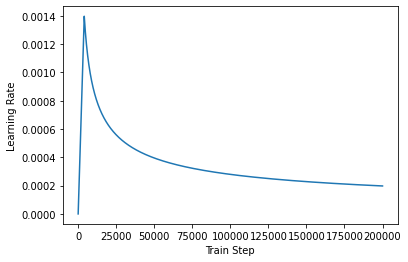

In [38]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [39]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r"", sentence)
  sentence = sentence.strip()
  return sentence

In [40]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)


    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [41]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  #print('Input: {}'.format(sentence))
  print('chatbot: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
output = predict("엄마 때문에 너무 화나")

chatbot: 어머니 때문에 화가 나신 일이 있군요 .


In [44]:
output = predict("엄마 때문에 너무 화나") # 하이퍼파라미터 조정 후

chatbot: 어머니 때문에 화가 나신 일이 있군요 .


In [ ]:
output = predict("자살생각이 계속 들어")

chatbot: 그런 생각이 드신 이유가 있나요 ?


In [45]:
output = predict("자살생각이 계속 들어") # 하이퍼파라미터 조정 후

chatbot: 자살하셔서 힘드시군요 .


In [ ]:
output = predict("대박이야")

chatbot: 대박이군요 .  무슨 일인가요 ?


In [46]:
output = predict("대박이야") # 하이퍼파라미터 조정 후

chatbot: 대박이군요 .  무슨 일인가요 ?


In [ ]:
output = predict("취업때문에 너무 스트레스 받아")

chatbot: 취업 때문에 스트레스가 많으시군요 .  어떤 점이 가장 힘드세요 ?


In [47]:
output = predict("취업때문에 너무 스트레스 받아") # 하이퍼파라미터 조정 후

chatbot: 취업 때문에 스트레스 받는군요 .  그런 감정이 드는 이유가 있나요 ?


In [ ]:
output = predict("나 이번에 합격했어!!")

chatbot: 합격하셨다니 좋으시겠어요 .


In [48]:
output = predict("나 이번에 합격했어!!")# 하이퍼파라미터 조정 후

chatbot: 드디어 합격하셨다니 좀 더 자세히 말씀해 주시겠어요 ?


In [43]:
output = predict("요즘 건강이 나빠진것같애")

chatbot: 건강이 오래 우선인데 많은 고민이 되시겠어요 .


In [58]:
output = predict("죽고 싶어")

chatbot: 죽고 싶으시다니 무슨 일 있으신가요 ?


Layer PositionalEncoding has arguments in `__init__` and therefore must override `get_config`오류
: https://lsjsj92.tistory.com/598

## BERT 챗봇

In [49]:
model_2 = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [50]:
df['embedding'] = df.apply(lambda row: model_2.encode(row.유저), axis = 1)

In [51]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [52]:
def return_answer(question):
    embedding = model_2.encode(question)
    df['score'] = df.apply(lambda x: cos_sim(x['embedding'], embedding), axis=1)
    re =df.loc[df['score'].idxmax()]['챗봇']
    print('chatbot:',re)

In [53]:
output = predict("요즘 건강이 나빠진것같애")

chatbot: 건강이 오래 우선인데 많은 고민이 되시겠어요 .


In [ ]:
return_answer('죽고싶다')

chatbot: 전문가와 상담을 받아보신 적이 있나요? 힘이 들 땐 도움을 받는 게 좋아요.


In [55]:
return_answer('자살할래')

chatbot: 오늘은 삶의 그래프를 한번 그려보면 어때요? 늘 안 좋은 일만 있었던 건 아닐 거예요.


In [56]:
return_answer('답이 없어')

chatbot: 힘드신가 봐요. 무슨 일 있으세요?


In [ ]:
return_answer('집에 큰일이 생겼어') # 2

chatbot: 마음이 힘드시겠어요.


In [ ]:
return_answer('너무 힘들어') #3

chatbot: 많이 곤란하셨을 거 같아요.


## 다중분류 모델(Bert)

### 이상치 제거

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0, flags=flags)


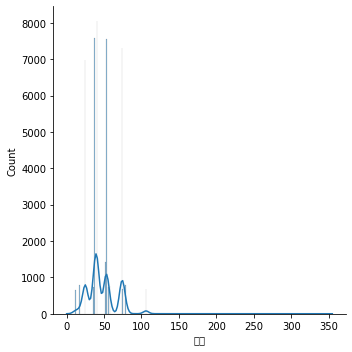

In [60]:
# label 이상치 확인
sns.displot(df['구분'],kde=True);

In [9]:
# 이상치 제거
import numpy as np

df['구분'] = df[df['구분'] <np.percentile(df['구분'], 98)]['구분']


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0, flags=flags)


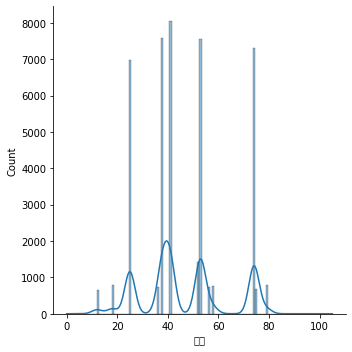

In [10]:
sns.displot(df['구분'],kde=True);

In [14]:
#이상치 제거
df = df[df['구분'].notna()]
# 구분 컬럼 int로 형변환
df['구분']=df['구분'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
print(df.shape)
df.head()

(44387, 3)


,구분,유저,챗봇
0,74,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.
1,41,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.
2,25,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.
3,74,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.
4,74,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?


In [16]:
df['구분'].nunique()

106

In [ ]:
df['구분'].unique()

array([ 74,  41,  25,  53,  38,  36,  79,  52,  56,  12,  18,  75,  58,
        30,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        13,  14,  15,  16,  17,  19,  20,  21,  22,  23,  24,  26,  27,
        28,  29,  31,  32,  33,  34,  35,  37,  39,  40,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  54,  55,  57,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  76,
        77,  78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105])

### KOBERT

In [17]:
device = torch.device("cuda:0") # #GPU 사용

In [18]:
bertmodel, vocab = get_pytorch_kobert_model() #BERT 모델, Vocabulary 불러오기

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [19]:
train, test = train_test_split(df, test_size= 0.2, random_state=1234)

In [22]:
data_train = []
for a, label in zip(train['유저'], train['구분']):
    data1 = []
    data1.append(a)
    data1.append(str(label))

    data_train.append(data1)

data_test = []
for b, label2 in zip(test['유저'], test['구분']):
    data2 = []
    data2.append(b)
    data2.append(str(label2))

    data_test.append(data2)

In [23]:
# koBERT 입력
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [49]:
# orignal version 1
max_len = 20
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5 
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [34]:
# version 2
max_len = 20
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20 # num_epochs= 5에서 20으로 변경
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# version 3
max_len = 40  # max_len 20 -> 40
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20 # num_epochs= 5에서 20으로 변경
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [61]:
# version 4
max_len = 40
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10 # num_epochs= 5 --> 10으로 변경
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# version 5
max_len = 40  
batch_size = 32  # batchsize 64 --> 32
warmup_ratio = 0.1
num_epochs = 5   # num_epochs= 20 --> 5로 변경
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# version  6
max_len = 40  
batch_size = 32  
warmup_ratio = 0.1
num_epochs = 10  # num_epochs= 5 --> 10로 변경
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [31]:
# version 7
max_len = 40  
batch_size = 32  
warmup_ratio = 0.1
num_epochs = 20  # num_epochs= 10 --> 20로 변경
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [90]:
# version 8
max_len = 60  # num_epochs= 40--> 60로 변경
batch_size = 64  
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [24]:
# version 9
max_len = 60
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10 # num_epochs= 5 --> 10으로 변경
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)

data_train = BERTDataset(data_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(data_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [25]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=106,   
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
            
        return self.classifier(out)

In [28]:
#BERT 모델 불러오기
model3 = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model3.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model3.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


(기준)num_epochs = 5, max_len = 40, batch_size = 64

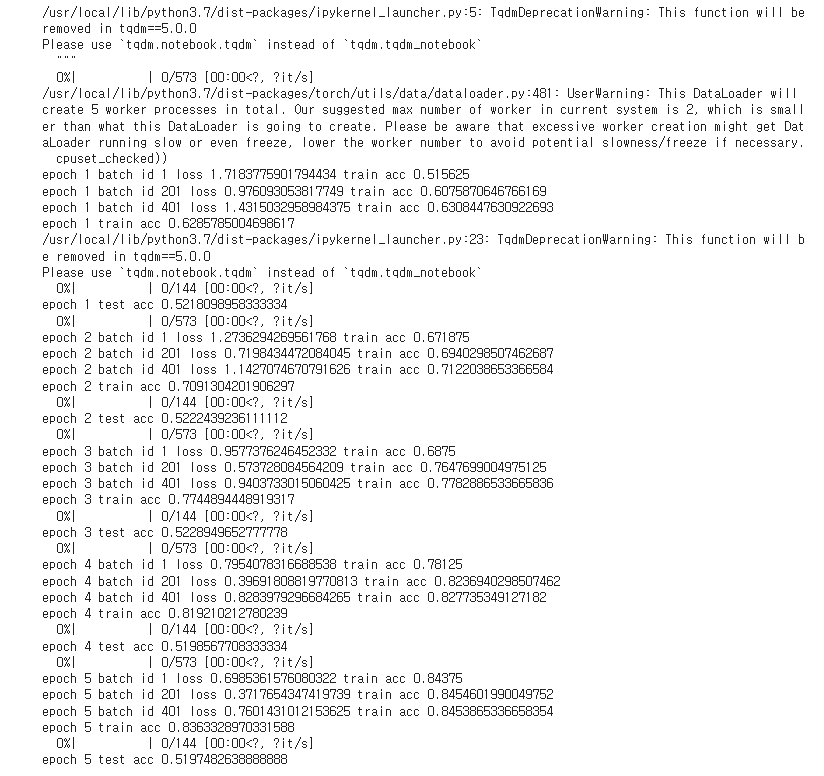

In [ ]:
# num_epochs = 20, max_len = 40
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

In [64]:
# num_epochs = 10, max_len = 40, batch_size = 64
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 4.611125946044922 train acc 0.015625
epoch 1 batch id 201 loss 1.587677240371704 train acc 0.4490049751243781
epoch 1 batch id 401 loss 0.5341406464576721 train acc 0.6444825436408977
epoch 1 train acc 0.7136202830188679


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 1 test acc 0.5871324679386926


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6105973124504089 train acc 0.84375
epoch 2 batch id 201 loss 0.14323844015598297 train acc 0.8911691542288557
epoch 2 batch id 401 loss 0.229893296957016 train acc 0.897677680798005
epoch 2 train acc 0.8992000254971952


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 2 test acc 0.593539842039412


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5203197598457336 train acc 0.828125
epoch 3 batch id 201 loss 0.25754743814468384 train acc 0.9039179104477612
epoch 3 batch id 401 loss 0.3527114689350128 train acc 0.90928927680798
epoch 3 train acc 0.911840791262961


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 3 test acc 0.5922837816703159


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.37064623832702637 train acc 0.921875
epoch 4 batch id 201 loss 0.3426351845264435 train acc 0.918143656716418
epoch 4 batch id 401 loss 0.1594875305891037 train acc 0.925303927680798
epoch 4 train acc 0.926705656127826


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 4 test acc 0.5863700344072569


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.4256889820098877 train acc 0.890625
epoch 5 batch id 201 loss 0.12671175599098206 train acc 0.931592039800995
epoch 5 batch id 401 loss 0.21679747104644775 train acc 0.9372272443890274
epoch 5 train acc 0.9395153408125106


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 5 test acc 0.5965993509540194


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.2575150728225708 train acc 0.953125
epoch 6 batch id 201 loss 0.027973150834441185 train acc 0.9468283582089553
epoch 6 batch id 401 loss 0.11292026191949844 train acc 0.9514884663341646
epoch 6 train acc 0.95263471018188


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 6 test acc 0.598129105411323


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.26719972491264343 train acc 0.921875
epoch 7 batch id 201 loss 0.08323922753334045 train acc 0.9556902985074627
epoch 7 batch id 401 loss 0.1787855327129364 train acc 0.9615414588528678
epoch 7 train acc 0.9621000127485977


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 7 test acc 0.5977234516734439


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.20229116082191467 train acc 0.953125
epoch 8 batch id 201 loss 0.06936769187450409 train acc 0.9666511194029851
epoch 8 batch id 401 loss 0.16747437417507172 train acc 0.9699579177057357
epoch 8 train acc 0.9698362867584566


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 8 test acc 0.6009833437597748


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.14224912226200104 train acc 0.953125
epoch 9 batch id 201 loss 0.00874033011496067 train acc 0.9731809701492538
epoch 9 batch id 401 loss 0.08623195439577103 train acc 0.974283042394015
epoch 9 train acc 0.9746563190549039


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 9 test acc 0.6053673365655302


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.16884401440620422 train acc 0.953125
epoch 10 batch id 201 loss 0.0072091869078576565 train acc 0.9738028606965174
epoch 10 batch id 401 loss 0.09894442558288574 train acc 0.9763092269326683
epoch 10 train acc 0.9766270397756247


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 10 test acc 0.6056361432593056


In [ ]:
# num_epochs = 20, max_len = 40
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/573 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 6.039574146270752 train acc 0.0
epoch 1 batch id 201 loss 4.126601696014404 train acc 0.08854166666666667
epoch 1 batch id 401 loss 2.271106004714966 train acc 0.15239245635910226
epoch 1 train acc 0.24057549671096792


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 1 test acc 0.5239800347222222


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.787835717201233 train acc 0.546875
epoch 2 batch id 201 loss 1.3344507217407227 train acc 0.5258861940298507
epoch 2 batch id 401 loss 1.627915859222412 train acc 0.5404847256857855
epoch 2 train acc 0.553020959189153


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 2 test acc 0.5951605902777778


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.5200707912445068 train acc 0.578125
epoch 3 batch id 201 loss 1.0977548360824585 train acc 0.5985696517412935
epoch 3 batch id 401 loss 1.5524094104766846 train acc 0.6090243142144638
epoch 3 train acc 0.6168277621157202


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 3 test acc 0.6026475694444444


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.2657570838928223 train acc 0.578125
epoch 4 batch id 201 loss 0.9110281467437744 train acc 0.6461442786069652
epoch 4 batch id 401 loss 1.3660016059875488 train acc 0.656834476309227
epoch 4 train acc 0.6667274969794603


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 4 test acc 0.6053602430555556


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.0160268545150757 train acc 0.65625
epoch 5 batch id 201 loss 0.8298022150993347 train acc 0.6981498756218906
epoch 5 batch id 401 loss 1.2919018268585205 train acc 0.7061253117206983
epoch 5 train acc 0.7160042455363136


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 5 test acc 0.6042751736111112


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.8419793248176575 train acc 0.71875
epoch 6 batch id 201 loss 0.6733144521713257 train acc 0.7501554726368159
epoch 6 batch id 401 loss 1.073342204093933 train acc 0.7554940773067331
epoch 6 train acc 0.7629295878641429


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 6 test acc 0.5935329861111112


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.8774147629737854 train acc 0.75
epoch 7 batch id 201 loss 0.613027811050415 train acc 0.7895677860696517
epoch 7 batch id 401 loss 0.8574603796005249 train acc 0.7946150249376559
epoch 7 train acc 0.798188095717546


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 7 test acc 0.5914713541666666


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.5831839442253113 train acc 0.84375
epoch 8 batch id 201 loss 0.48949870467185974 train acc 0.824393656716418
epoch 8 batch id 401 loss 0.5587847232818604 train acc 0.8289432668329177
epoch 8 train acc 0.8308812424486508


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 8 test acc 0.5936414930555556


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.5340102314949036 train acc 0.84375
epoch 9 batch id 201 loss 0.33958685398101807 train acc 0.8478700248756219
epoch 9 batch id 401 loss 0.5263347625732422 train acc 0.8554005610972568
epoch 9 train acc 0.8575479930191972


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 9 test acc 0.587890625


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.5057892799377441 train acc 0.875
epoch 10 batch id 201 loss 0.25573545694351196 train acc 0.8761660447761194
epoch 10 batch id 401 loss 0.5216283202171326 train acc 0.8828709476309227
epoch 10 train acc 0.8836169284467714


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 10 test acc 0.5845269097222222


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.35108646750450134 train acc 0.875
epoch 11 batch id 201 loss 0.26218193769454956 train acc 0.892568407960199
epoch 11 batch id 401 loss 0.31140393018722534 train acc 0.898067331670823
epoch 11 train acc 0.9006053664921466


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 11 test acc 0.5751953125


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.40510648488998413 train acc 0.859375
epoch 12 batch id 201 loss 0.11988821625709534 train acc 0.9124689054726368
epoch 12 batch id 401 loss 0.3902006447315216 train acc 0.9166147132169576
epoch 12 train acc 0.9177028795811518


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 12 test acc 0.5913628472222222


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.23122099041938782 train acc 0.921875
epoch 13 batch id 201 loss 0.08650340139865875 train acc 0.9233519900497512
epoch 13 batch id 401 loss 0.284034788608551 train acc 0.9286159600997507
epoch 13 train acc 0.9300010907504364


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 13 test acc 0.5888671875


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.22212223708629608 train acc 0.921875
epoch 14 batch id 201 loss 0.05122072994709015 train acc 0.9360230099502488
epoch 14 batch id 401 loss 0.2625274062156677 train acc 0.9406951371571073
epoch 14 train acc 0.9403359511343804


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 14 test acc 0.5904947916666666


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.28642866015434265 train acc 0.9375
epoch 15 batch id 201 loss 0.09640829265117645 train acc 0.9451181592039801
epoch 15 batch id 401 loss 0.1458349972963333 train acc 0.948176433915212
epoch 15 train acc 0.9475894415357766


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 15 test acc 0.5924479166666666


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.11891576647758484 train acc 0.984375
epoch 16 batch id 201 loss 0.028099127113819122 train acc 0.9518812189054726
epoch 16 batch id 401 loss 0.10303767025470734 train acc 0.9539043017456359
epoch 16 train acc 0.9539157940663177


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 16 test acc 0.5875651041666666


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.09588369727134705 train acc 0.984375
epoch 17 batch id 201 loss 0.008535505272448063 train acc 0.9560789800995025
epoch 17 batch id 401 loss 0.07037880271673203 train acc 0.9575670199501247
epoch 17 train acc 0.9568608202443281


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 17 test acc 0.5922309027777778


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.0968272015452385 train acc 0.984375
epoch 18 batch id 201 loss 0.032154910266399384 train acc 0.9594216417910447
epoch 18 batch id 401 loss 0.1839790642261505 train acc 0.9607621571072319
epoch 18 train acc 0.9601603403141361


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 18 test acc 0.5923394097222222


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.0846870020031929 train acc 0.984375
epoch 19 batch id 201 loss 0.05881425365805626 train acc 0.9620646766169154
epoch 19 batch id 401 loss 0.11369403451681137 train acc 0.9624376558603491
epoch 19 train acc 0.9622873036649214


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 19 test acc 0.5953776041666666


  0%|          | 0/573 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.08269911259412766 train acc 0.984375
epoch 20 batch id 201 loss 0.010935293510556221 train acc 0.9631529850746269
epoch 20 batch id 401 loss 0.11732739210128784 train acc 0.9639183291770573
epoch 20 train acc 0.9637052792321117


  0%|          | 0/144 [00:00<?, ?it/s]

epoch 20 test acc 0.5934244791666666


In [ ]:
# num_epochs = 5, max_len = 40, batch_size = 32
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1145 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 5.923779487609863 train acc 0.0
epoch 1 batch id 201 loss 2.7534735202789307 train acc 0.355410447761194
epoch 1 batch id 401 loss 0.6014512181282043 train acc 0.5889962593516209
epoch 1 batch id 601 loss 0.5802291035652161 train acc 0.6838082362728786
epoch 1 batch id 801 loss 1.3700593709945679 train acc 0.7315074906367042
epoch 1 batch id 1001 loss 0.34949004650115967 train acc 0.7606768231768232
epoch 1 train acc 0.7756550218340611


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 1 test acc 0.570993031358885


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.18764853477478027 train acc 0.96875
epoch 2 batch id 201 loss 0.5691956281661987 train acc 0.8737562189054726
epoch 2 batch id 401 loss 0.3884342908859253 train acc 0.8798316708229427
epoch 2 batch id 601 loss 0.5774133205413818 train acc 0.88233153078203
epoch 2 batch id 801 loss 0.9361171126365662 train acc 0.8854166666666666
epoch 2 batch id 1001 loss 0.4084267020225525 train acc 0.8878933566433567
epoch 2 train acc 0.888646288209607


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 2 test acc 0.5790505226480837


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.1449289172887802 train acc 0.9375
epoch 3 batch id 201 loss 0.36834508180618286 train acc 0.9043843283582089
epoch 3 batch id 401 loss 0.08912177383899689 train acc 0.9099127182044888
epoch 3 batch id 601 loss 0.4584563076496124 train acc 0.9137375207986689
epoch 3 batch id 801 loss 1.0163803100585938 train acc 0.916393570536829
epoch 3 batch id 1001 loss 0.22995930910110474 train acc 0.9186750749250749
epoch 3 train acc 0.9201692139737991


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 3 test acc 0.5803571428571429


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.0971095934510231 train acc 0.96875
epoch 4 batch id 201 loss 0.39984235167503357 train acc 0.9357898009950248
epoch 4 batch id 401 loss 0.03380581736564636 train acc 0.9385910224438903
epoch 4 batch id 601 loss 0.20366661250591278 train acc 0.9421797004991681
epoch 4 batch id 801 loss 0.47772645950317383 train acc 0.9438982521847691
epoch 4 batch id 1001 loss 0.00987198669463396 train acc 0.9441183816183816
epoch 4 train acc 0.9446779475982533


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 4 test acc 0.5940766550522648


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.011046048253774643 train acc 1.0
epoch 5 batch id 201 loss 0.2110348641872406 train acc 0.9528917910447762
epoch 5 batch id 401 loss 0.03146521747112274 train acc 0.9523846633416458
epoch 5 batch id 601 loss 0.16181978583335876 train acc 0.9545029118136439
epoch 5 batch id 801 loss 0.2060813456773758 train acc 0.954939138576779
epoch 5 batch id 1001 loss 0.06698454916477203 train acc 0.9548264235764236
epoch 5 train acc 0.9545851528384279


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 5 test acc 0.5970165505226481


In [ ]:
# num_epochs = 10, max_len = 40, batch_size = 32
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1145 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 6.1619157791137695 train acc 0.0
epoch 1 batch id 201 loss 4.043096542358398 train acc 0.12935323383084577
epoch 1 batch id 401 loss 0.7234981656074524 train acc 0.470464463840399
epoch 1 batch id 601 loss 0.5466318130493164 train acc 0.6037853577371048
epoch 1 batch id 801 loss 0.6047177314758301 train acc 0.6851201622971286
epoch 1 batch id 1001 loss 0.30183714628219604 train acc 0.7329857642357642
epoch 1 train acc 0.7564137554585153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 1 test acc 0.5839503484320557


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.18758569657802582 train acc 0.9375
epoch 2 batch id 201 loss 0.3830449879169464 train acc 0.9079601990049752
epoch 2 batch id 401 loss 0.2285497486591339 train acc 0.9133416458852868
epoch 2 batch id 601 loss 0.3963853418827057 train acc 0.9177412645590682
epoch 2 batch id 801 loss 0.43854498863220215 train acc 0.9179931335830213
epoch 2 batch id 1001 loss 0.2272108942270279 train acc 0.9168956043956044
epoch 2 train acc 0.9170032751091703


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 2 test acc 0.578397212543554


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.29094991087913513 train acc 0.9375
epoch 3 batch id 201 loss 0.3852035701274872 train acc 0.9081156716417911
epoch 3 batch id 401 loss 0.05850077420473099 train acc 0.9145885286783042
epoch 3 batch id 601 loss 0.32071366906166077 train acc 0.9189371880199667
epoch 3 batch id 801 loss 0.3465702533721924 train acc 0.9208411360799001
epoch 3 batch id 1001 loss 0.2933543622493744 train acc 0.9212974525474525
epoch 3 train acc 0.9211244541484717


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 3 test acc 0.586890243902439


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.16048136353492737 train acc 0.9375
epoch 4 batch id 201 loss 0.16190539300441742 train acc 0.9211753731343284
epoch 4 batch id 401 loss 0.2264845222234726 train acc 0.9273690773067331
epoch 4 batch id 601 loss 0.3344748318195343 train acc 0.9303764559068219
epoch 4 batch id 801 loss 0.47301411628723145 train acc 0.931999063670412
epoch 4 batch id 1001 loss 0.14394186437129974 train acc 0.9320054945054945
epoch 4 train acc 0.9330513100436681


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 4 test acc 0.5883057491289199


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.031728990375995636 train acc 1.0
epoch 5 batch id 201 loss 0.2903820276260376 train acc 0.9340796019900498
epoch 5 batch id 401 loss 0.30894404649734497 train acc 0.9380455112219451
epoch 5 batch id 601 loss 0.01756994239985943 train acc 0.9416077371048253
epoch 5 batch id 801 loss 0.7057998776435852 train acc 0.9422596754057428
epoch 5 batch id 1001 loss 0.05217587947845459 train acc 0.941776973026973
epoch 5 train acc 0.9425491266375546


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 5 test acc 0.5843858885017421


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.03357946500182152 train acc 0.96875
epoch 6 batch id 201 loss 0.2689018249511719 train acc 0.9480721393034826
epoch 6 batch id 401 loss 0.005410912446677685 train acc 0.94856608478803
epoch 6 batch id 601 loss 0.013402793556451797 train acc 0.9516430948419301
epoch 6 batch id 801 loss 0.361579030752182 train acc 0.9519740948813983
epoch 6 batch id 1001 loss 0.0026127484161406755 train acc 0.9522352647352648
epoch 6 train acc 0.9523744541484717


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 6 test acc 0.5914634146341463


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.009317868389189243 train acc 1.0
epoch 7 batch id 201 loss 0.18887649476528168 train acc 0.9549129353233831
epoch 7 batch id 401 loss 0.001978076994419098 train acc 0.9583073566084788
epoch 7 batch id 601 loss 0.02144624851644039 train acc 0.9603265391014975
epoch 7 batch id 801 loss 0.1986197680234909 train acc 0.9604400749063671
epoch 7 batch id 1001 loss 0.0035949170123785734 train acc 0.9600087412587412
epoch 7 train acc 0.9604257641921398


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 7 test acc 0.5909189895470384


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.06019800901412964 train acc 0.96875
epoch 8 batch id 201 loss 0.16211292147636414 train acc 0.9643967661691543
epoch 8 batch id 401 loss 0.0017908589215949178 train acc 0.9647755610972568
epoch 8 batch id 601 loss 0.0032090232707560062 train acc 0.9660981697171381
epoch 8 batch id 801 loss 0.17677262425422668 train acc 0.9656289013732834
epoch 8 batch id 1001 loss 0.012719931080937386 train acc 0.9651910589410589
epoch 8 train acc 0.9653657205240175


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 8 test acc 0.5952743902439024


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.001870719832368195 train acc 1.0
epoch 9 batch id 201 loss 0.16013985872268677 train acc 0.9668843283582089
epoch 9 batch id 401 loss 0.0020886349957436323 train acc 0.9656327930174564
epoch 9 batch id 601 loss 0.0021422128193080425 train acc 0.9673980865224625
epoch 9 batch id 801 loss 0.17134681344032288 train acc 0.966916354556804
epoch 9 batch id 1001 loss 0.001619225600734353 train acc 0.9660651848151848
epoch 9 train acc 0.9662390829694323


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 9 test acc 0.600065331010453


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.001325073535554111 train acc 1.0
epoch 10 batch id 201 loss 0.15388870239257812 train acc 0.9685945273631841
epoch 10 batch id 401 loss 0.0424039289355278 train acc 0.9693734413965087
epoch 10 batch id 601 loss 0.0028052376583218575 train acc 0.9708298668885191
epoch 10 batch id 801 loss 0.16549453139305115 train acc 0.9699594257178527
epoch 10 batch id 1001 loss 0.0015024064341560006 train acc 0.9696241258741258
epoch 10 train acc 0.9693504366812227


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 10 test acc 0.6002831010452961


In [ ]:
# num_epochs = 20, max_len = 40, batch_size = 32
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1145 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 5.824936866760254 train acc 0.0
epoch 1 batch id 201 loss 4.730804920196533 train acc 0.049129353233830844
epoch 1 batch id 401 loss 2.1024601459503174 train acc 0.37609102244389025
epoch 1 batch id 601 loss 0.9591562151908875 train acc 0.5378015806988353
epoch 1 batch id 801 loss 0.455686092376709 train acc 0.6285892634207241
epoch 1 batch id 1001 loss 0.15189941227436066 train acc 0.694212037962038
epoch 1 train acc 0.7280021834061136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 1 test acc 0.5754573170731707


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.055553924292325974 train acc 1.0
epoch 2 batch id 201 loss 0.2698204815387726 train acc 0.9592661691542289
epoch 2 batch id 401 loss 0.015478202141821384 train acc 0.9608011221945137
epoch 2 batch id 601 loss 0.07260511070489883 train acc 0.9599625623960066
epoch 2 batch id 801 loss 0.6273672580718994 train acc 0.95770911360799
epoch 2 batch id 1001 loss 0.21736013889312744 train acc 0.9545142357642358
epoch 2 train acc 0.9525109170305677


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 2 test acc 0.5860191637630662


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.2710658609867096 train acc 0.9375
epoch 3 batch id 201 loss 0.2161986082792282 train acc 0.9311256218905473
epoch 3 batch id 401 loss 0.14062626659870148 train acc 0.9325124688279302
epoch 3 batch id 601 loss 0.034239016473293304 train acc 0.9336522462562395
epoch 3 batch id 801 loss 0.29558178782463074 train acc 0.9335986267166042
epoch 3 batch id 1001 loss 0.11910807341337204 train acc 0.933503996003996
epoch 3 train acc 0.933160480349345


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 3 test acc 0.5733885017421603


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.04647281393408775 train acc 1.0
epoch 4 batch id 201 loss 0.2308425009250641 train acc 0.9309701492537313
epoch 4 batch id 401 loss 0.2562066614627838 train acc 0.9315773067331671
epoch 4 batch id 601 loss 0.13314922153949738 train acc 0.9342242096505824
epoch 4 batch id 801 loss 0.22159215807914734 train acc 0.9343008739076155
epoch 4 batch id 1001 loss 0.42586466670036316 train acc 0.934502997002997
epoch 4 train acc 0.9354950453476654


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 4 test acc 0.5837325783972126


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.04392904043197632 train acc 0.96875
epoch 5 batch id 201 loss 0.18932205438613892 train acc 0.931747512437811
epoch 5 batch id 401 loss 0.006593979895114899 train acc 0.9363310473815462
epoch 5 batch id 601 loss 0.3668445646762848 train acc 0.9378119800332779
epoch 5 batch id 801 loss 0.22121919691562653 train acc 0.938397315855181
epoch 5 batch id 1001 loss 0.12405446171760559 train acc 0.9379682817182817
epoch 5 train acc 0.9377456331877729


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 5 test acc 0.5908101045296167


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.09449877589941025 train acc 0.96875
epoch 6 batch id 201 loss 0.18742355704307556 train acc 0.9362562189054726
epoch 6 batch id 401 loss 0.09017318487167358 train acc 0.9379675810473815
epoch 6 batch id 601 loss 0.1288534551858902 train acc 0.9395278702163061
epoch 6 batch id 801 loss 0.29848557710647583 train acc 0.9400749063670412
epoch 6 batch id 1001 loss 0.12198550999164581 train acc 0.9404345654345654
epoch 6 train acc 0.9411026200873363


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 6 test acc 0.5861280487804879


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.11715999990701675 train acc 0.9375
epoch 7 batch id 201 loss 0.17810161411762238 train acc 0.9426305970149254
epoch 7 batch id 401 loss 0.451710969209671 train acc 0.944357855361596
epoch 7 batch id 601 loss 0.23016317188739777 train acc 0.9453514975041597
epoch 7 batch id 801 loss 0.20097728073596954 train acc 0.9443664169787765
epoch 7 batch id 1001 loss 0.004210233222693205 train acc 0.9453359140859141
epoch 7 train acc 0.9459334061135372


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 7 test acc 0.5878702090592335


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.06897544115781784 train acc 0.96875
epoch 8 batch id 201 loss 0.16360177099704742 train acc 0.9477611940298507
epoch 8 batch id 401 loss 0.005798823665827513 train acc 0.9495791770573566
epoch 8 batch id 601 loss 0.015882719308137894 train acc 0.9512271214642263
epoch 8 batch id 801 loss 0.2834705412387848 train acc 0.950335518102372
epoch 8 batch id 1001 loss 0.08824038505554199 train acc 0.9506118881118881
epoch 8 train acc 0.9510644104803494


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 8 test acc 0.5907012195121951


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.023355068638920784 train acc 1.0
epoch 9 batch id 201 loss 0.18239185214042664 train acc 0.951181592039801
epoch 9 batch id 401 loss 0.04348106309771538 train acc 0.9522288029925187
epoch 9 batch id 601 loss 0.1819256842136383 train acc 0.9527350249584027
epoch 9 batch id 801 loss 0.21777698397636414 train acc 0.9518570536828964
epoch 9 batch id 1001 loss 0.010662301443517208 train acc 0.9515796703296703
epoch 9 train acc 0.9521288209606987


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 9 test acc 0.5861280487804879


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.2330377995967865 train acc 0.96875
epoch 10 batch id 201 loss 0.15660984814167023 train acc 0.9538246268656716
epoch 10 batch id 401 loss 0.0010580840753391385 train acc 0.9569046134663342
epoch 10 batch id 601 loss 0.26048269867897034 train acc 0.9590266222961731
epoch 10 batch id 801 loss 0.2558916509151459 train acc 0.9591136079900124
epoch 10 batch id 1001 loss 0.049912404268980026 train acc 0.9586975524475524
epoch 10 train acc 0.9591430131004367


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 10 test acc 0.5892857142857143


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.0047577605582773685 train acc 1.0
epoch 11 batch id 201 loss 0.19071485102176666 train acc 0.9578669154228856
epoch 11 batch id 401 loss 0.021323172375559807 train acc 0.9602556109725686
epoch 11 batch id 601 loss 0.002826123731210828 train acc 0.9616264559068219
epoch 11 batch id 801 loss 0.18354704976081848 train acc 0.9609862671660424
epoch 11 batch id 1001 loss 0.08496350049972534 train acc 0.9608516483516484
epoch 11 train acc 0.9612718340611354


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 11 test acc 0.5932055749128919


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.02756786346435547 train acc 1.0
epoch 12 batch id 201 loss 0.46538060903549194 train acc 0.964863184079602
epoch 12 batch id 401 loss 0.02073870599269867 train acc 0.9652431421446384
epoch 12 batch id 601 loss 0.3816399574279785 train acc 0.9658381863560732
epoch 12 batch id 801 loss 0.12904231250286102 train acc 0.9649656679151061
epoch 12 batch id 1001 loss 0.0014923346461728215 train acc 0.9648164335664335
epoch 12 train acc 0.9650382096069869


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 12 test acc 0.5920078397212544


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.0007397447479888797 train acc 1.0
epoch 13 batch id 201 loss 0.15001064538955688 train acc 0.9692164179104478
epoch 13 batch id 401 loss 0.0006239783833734691 train acc 0.9688279301745636
epoch 13 batch id 601 loss 0.001368923345580697 train acc 0.9695299500831946
epoch 13 batch id 801 loss 0.1438634991645813 train acc 0.9689060549313359
epoch 13 batch id 1001 loss 0.0006177687318995595 train acc 0.9686563436563437
epoch 13 train acc 0.9688318777292576


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 13 test acc 0.5970165505226481


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.0006597714964300394 train acc 1.0
epoch 14 batch id 201 loss 0.17362506687641144 train acc 0.9701492537313433
epoch 14 batch id 401 loss 0.0005374092143028975 train acc 0.9708541147132169
epoch 14 batch id 601 loss 0.008444361388683319 train acc 0.9715058236272879
epoch 14 batch id 801 loss 0.13611263036727905 train acc 0.9710127965043696
epoch 14 batch id 1001 loss 0.0005603388417512178 train acc 0.9705606893106893
epoch 14 train acc 0.9707150655021834


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 14 test acc 0.603331881533101


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.005511465482413769 train acc 1.0
epoch 15 batch id 201 loss 0.17387956380844116 train acc 0.9729477611940298
epoch 15 batch id 401 loss 0.0005946455057710409 train acc 0.9724127182044888
epoch 15 batch id 601 loss 0.007777214981615543 train acc 0.9729097337770383
epoch 15 batch id 801 loss 0.11969869583845139 train acc 0.9724172908863921
epoch 15 batch id 1001 loss 0.0662798285484314 train acc 0.9720591908091908
epoch 15 train acc 0.9722434497816594


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 15 test acc 0.6035496515679443


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.0006471652304753661 train acc 1.0
epoch 16 batch id 201 loss 0.34832340478897095 train acc 0.9727922885572139
epoch 16 batch id 401 loss 0.0005250857793726027 train acc 0.973893391521197
epoch 16 batch id 601 loss 0.016083290800452232 train acc 0.9745736272878536
epoch 16 batch id 801 loss 0.13516591489315033 train acc 0.9740168539325843
epoch 16 batch id 1001 loss 0.0023165142629295588 train acc 0.9734328171828172
epoch 16 train acc 0.9733897379912664


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 16 test acc 0.6050740418118467


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.002766245510429144 train acc 1.0
epoch 17 batch id 201 loss 0.15858352184295654 train acc 0.974502487562189
epoch 17 batch id 401 loss 0.0006864872411824763 train acc 0.9747506234413965
epoch 17 batch id 601 loss 0.0006073330878280103 train acc 0.9751455906821963
epoch 17 batch id 801 loss 0.13617348670959473 train acc 0.9741338951310862
epoch 17 batch id 1001 loss 0.002882254309952259 train acc 0.9736201298701299
epoch 17 train acc 0.9736626637554585


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 17 test acc 0.6049651567944251


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.0006407081382349133 train acc 1.0
epoch 18 batch id 201 loss 0.1422349065542221 train acc 0.9752798507462687
epoch 18 batch id 401 loss 0.017511552199721336 train acc 0.9745947630922693
epoch 18 batch id 601 loss 0.00212015095166862 train acc 0.9754575707154742
epoch 18 batch id 801 loss 0.11790507286787033 train acc 0.9746800873907615
epoch 18 batch id 1001 loss 0.041715431958436966 train acc 0.9739947552447552
epoch 18 train acc 0.9736080786026201


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 18 test acc 0.6032229965156795


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.0006727873696945608 train acc 1.0
epoch 19 batch id 201 loss 0.13831724226474762 train acc 0.9763681592039801
epoch 19 batch id 401 loss 0.0003581434430088848 train acc 0.9755299251870324
epoch 19 batch id 601 loss 0.00044294193503446877 train acc 0.9757175540765392
epoch 19 batch id 801 loss 0.12936215102672577 train acc 0.9751092384519351
epoch 19 batch id 1001 loss 0.058745887130498886 train acc 0.9745879120879121
epoch 19 train acc 0.973990174672489


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 19 test acc 0.6049651567944251


  0%|          | 0/1145 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.0004443555953912437 train acc 1.0
epoch 20 batch id 201 loss 0.15471254289150238 train acc 0.9757462686567164
epoch 20 batch id 401 loss 0.00025406532222405076 train acc 0.9767768079800498
epoch 20 batch id 601 loss 0.0005172624951228499 train acc 0.9764455074875208
epoch 20 batch id 801 loss 0.11191388964653015 train acc 0.9755774032459426
epoch 20 batch id 1001 loss 0.06191761791706085 train acc 0.9753683816183816
epoch 20 train acc 0.9750818777292577


  0%|          | 0/287 [00:00<?, ?it/s]

epoch 20 test acc 0.6048562717770035


In [57]:
# num_epochs = 10, max_len = 60, batch_size = 64
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 4.928967475891113 train acc 0.0
epoch 1 batch id 201 loss 2.0495429039001465 train acc 0.34367226368159204
epoch 1 batch id 401 loss 1.1398279666900635 train acc 0.5175732543640897
epoch 1 train acc 0.568786652218256


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 1 test acc 0.6151225758523616


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.2052215337753296 train acc 0.65625
epoch 2 batch id 201 loss 0.7255816459655762 train acc 0.7136971393034826
epoch 2 batch id 401 loss 0.8618130683898926 train acc 0.7378818578553616
epoch 2 train acc 0.7461701087880334


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 2 test acc 0.6135048482952769


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9218541979789734 train acc 0.71875
epoch 3 batch id 201 loss 0.5386670827865601 train acc 0.7706778606965174
epoch 3 batch id 401 loss 0.8381059765815735 train acc 0.7879130299251871
epoch 3 train acc 0.7939800059493455


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 3 test acc 0.6106261729746638


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.7797561883926392 train acc 0.75
epoch 4 batch id 201 loss 0.49854907393455505 train acc 0.8108675373134329
epoch 4 batch id 401 loss 0.6324928402900696 train acc 0.8208385286783042
epoch 4 train acc 0.8282317695053544


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 4 test acc 0.6003528698780106


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.7185423970222473 train acc 0.765625
epoch 5 batch id 201 loss 0.3316681385040283 train acc 0.8565764925373134
epoch 5 batch id 401 loss 0.32563430070877075 train acc 0.8645573566084788
epoch 5 train acc 0.8679054054054054


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 5 test acc 0.6008025101657805


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.6030156016349792 train acc 0.8125
epoch 6 batch id 201 loss 0.3435966372489929 train acc 0.8812966417910447
epoch 6 batch id 401 loss 0.2269435077905655 train acc 0.892534289276808
epoch 6 train acc 0.8969536163522013


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 6 test acc 0.5955192367844855


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.59041827917099 train acc 0.828125
epoch 7 batch id 201 loss 0.2118465006351471 train acc 0.9067164179104478
epoch 7 batch id 401 loss 0.16601988673210144 train acc 0.9143547381546134
epoch 7 train acc 0.9176238738738739


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 7 test acc 0.5944635595871129


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.4076796770095825 train acc 0.890625
epoch 8 batch id 201 loss 0.10157786309719086 train acc 0.9252953980099502
epoch 8 batch id 401 loss 0.1838153898715973 train acc 0.932161783042394
epoch 8 train acc 0.9343128505864354


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 8 test acc 0.5987595792930872


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.2625001072883606 train acc 0.921875
epoch 9 batch id 201 loss 0.0892217606306076 train acc 0.9389769900497512
epoch 9 batch id 401 loss 0.14751121401786804 train acc 0.9427213216957606
epoch 9 train acc 0.9437101606323304


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 9 test acc 0.603255982170785


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.2403489351272583 train acc 0.90625
epoch 10 batch id 201 loss 0.055927421897649765 train acc 0.9487717661691543
epoch 10 batch id 401 loss 0.17627204954624176 train acc 0.950826059850374
epoch 10 train acc 0.9509736741458439


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 10 test acc 0.6044240694401001


In [44]:
# num_epochs = 5, max_len = 60, batch_size = 64
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 4.726019859313965 train acc 0.0
epoch 1 batch id 201 loss 1.9160031080245972 train acc 0.19698383084577115
epoch 1 batch id 401 loss 1.5845766067504883 train acc 0.35286783042394015
epoch 1 train acc 0.4147256926738059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 1 test acc 0.5997468329684079


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.6211824417114258 train acc 0.515625
epoch 2 batch id 201 loss 1.1412197351455688 train acc 0.5942164179104478
epoch 2 batch id 401 loss 1.204671025276184 train acc 0.6091022443890274
epoch 2 train acc 0.6168382415434303


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 2 test acc 0.6243402017516422


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.4013992547988892 train acc 0.625
epoch 3 batch id 201 loss 0.9086723327636719 train acc 0.6551616915422885
epoch 3 batch id 401 loss 1.108792781829834 train acc 0.6678615960099751
epoch 3 train acc 0.6743668196498385


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 3 test acc 0.6247214185173601


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.2736717462539673 train acc 0.625
epoch 4 batch id 201 loss 0.7558192014694214 train acc 0.7121424129353234
epoch 4 batch id 401 loss 0.8867312669754028 train acc 0.7249844139650873
epoch 4 train acc 0.7290189954105049


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 4 test acc 0.6298482952768221


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.0898046493530273 train acc 0.6875
epoch 5 batch id 201 loss 0.672836422920227 train acc 0.757695895522388
epoch 5 batch id 401 loss 0.8275564312934875 train acc 0.7644170822942643
epoch 5 train acc 0.7671054309026006


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 5 test acc 0.6308159993744136


In [29]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 4.701194763183594 train acc 0.015625
epoch 1 batch id 201 loss 2.41459584236145 train acc 0.12181281094527363
epoch 1 batch id 401 loss 1.3946411609649658 train acc 0.28775716957605985
epoch 1 train acc 0.36205592384837665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 1 test acc 0.5840729590240851


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.6160491704940796 train acc 0.515625
epoch 2 batch id 201 loss 1.1974486112594604 train acc 0.5796019900497512
epoch 2 batch id 401 loss 1.231987476348877 train acc 0.5974127182044888
epoch 2 train acc 0.6067700365459799


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 2 test acc 0.6186317250547388


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.318739414215088 train acc 0.625
epoch 3 batch id 201 loss 0.9248478412628174 train acc 0.6395366915422885
epoch 3 batch id 401 loss 1.064703345298767 train acc 0.6505221321695761
epoch 3 train acc 0.6581506034336223


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 3 test acc 0.6238465749139819


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.0717781782150269 train acc 0.640625
epoch 4 batch id 201 loss 0.7444801330566406 train acc 0.6908426616915423
epoch 4 batch id 401 loss 0.9251698851585388 train acc 0.7024236284289277
epoch 4 train acc 0.7121600373958864


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 4 test acc 0.6219795902408508


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.9727200865745544 train acc 0.6875
epoch 5 batch id 201 loss 0.5634765625 train acc 0.7499222636815921
epoch 5 batch id 401 loss 0.6904910206794739 train acc 0.7552213216957606
epoch 5 train acc 0.7626561703212646


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 5 test acc 0.6145849624648108


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.8008230924606323 train acc 0.734375
epoch 6 batch id 201 loss 0.46918222308158875 train acc 0.794931592039801
epoch 6 batch id 401 loss 0.5965844988822937 train acc 0.8025639027431422
epoch 6 train acc 0.8095885390107088


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 6 test acc 0.6065109868626838


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.7618659138679504 train acc 0.765625
epoch 7 batch id 201 loss 0.3869362473487854 train acc 0.8373756218905473
epoch 7 batch id 401 loss 0.5968990325927734 train acc 0.8425810473815462
epoch 7 train acc 0.8489524902260751


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 7 test acc 0.6084024085079762


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.5904179811477661 train acc 0.796875
epoch 8 batch id 201 loss 0.27208179235458374 train acc 0.8720460199004975
epoch 8 batch id 401 loss 0.4413425326347351 train acc 0.8754286159600998
epoch 8 train acc 0.8789132882882883


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 8 test acc 0.6127619643415703


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.554110586643219 train acc 0.828125
epoch 9 batch id 201 loss 0.27249473333358765 train acc 0.8931902985074627
epoch 9 batch id 401 loss 0.39656391739845276 train acc 0.8946773690773068
epoch 9 train acc 0.8969031531531532


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 9 test acc 0.6114130434782609


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.44710594415664673 train acc 0.84375
epoch 10 batch id 201 loss 0.22109434008598328 train acc 0.9060167910447762
epoch 10 batch id 401 loss 0.2620764374732971 train acc 0.9040289900249376
epoch 10 train acc 0.9063626126126126


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 10 test acc 0.6150101657804192


In [76]:
# 최종
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model3.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model3.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model3(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 4.705502033233643 train acc 0.03125
epoch 1 batch id 201 loss 1.843277096748352 train acc 0.19162002487562188
epoch 1 batch id 401 loss 1.4307374954223633 train acc 0.3612063591022444
epoch 1 train acc 0.4205310853306136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 1 test acc 0.6107385830466062


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.559470534324646 train acc 0.609375
epoch 2 batch id 201 loss 1.169882893562317 train acc 0.6001243781094527
epoch 2 batch id 401 loss 1.1404742002487183 train acc 0.6172459476309227
epoch 2 train acc 0.6251035823559409


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 2 test acc 0.619731388802002


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.3097723722457886 train acc 0.640625
epoch 3 batch id 201 loss 0.9644543528556824 train acc 0.6527518656716418
epoch 3 batch id 401 loss 1.029515027999878 train acc 0.6701995012468828
epoch 3 train acc 0.6787305583885772


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 3 test acc 0.6296674616828277


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.0428053140640259 train acc 0.671875
epoch 4 batch id 201 loss 0.7685501575469971 train acc 0.7124533582089553
epoch 4 batch id 401 loss 0.8638968467712402 train acc 0.7280236907730673
epoch 4 train acc 0.7354942206357301


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 4 test acc 0.6248338285893025


  0%|          | 0/555 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.8905095458030701 train acc 0.671875
epoch 5 batch id 201 loss 0.6915506720542908 train acc 0.7563743781094527
epoch 5 batch id 401 loss 0.7595965266227722 train acc 0.76714463840399
epoch 5 train acc 0.7702808941016488


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 5 test acc 0.6304983187363153


In [ ]:
# 새로운 문장 테스트
tokenizer2 = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer2, vocab, lower=False)
bye = [20, 74,103,104, 92, 97]
bye2 = [88,89,90]
family =  [9, 34, 84,93,94]
welfare = [5, 105]
health= [3,4,8, 95, 99,]
depression = [0,1, 12, 16,19, 31,32,37,48, 59, 60, 61,62, 65, 66, 67 ,69, 70, 71, 72,76,81,87]
anx =[21,26, 41, 42, 43, 44, 45, 78]
ptsd =[27,28,33]
anger = [35, 36, 38,39,82]
stress =[18, 23,77, 79,85,86]
phy = [14,15.49,102]
def predict2(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model3.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model3(token_ids, valid_length, segment_ids)

        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) in bye:
               print("오늘 대화 즐거웠어요. 다음에 또 대화해요 :)")
            elif np.argmax(logits) in bye2:
               print("당신의 용기있는 선택에 응원을 보냅니다. 주저가 되실때 저를 다시 불러주세요 ")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7')             
            elif np.argmax(logits) in family: 
               print("당신에게 도움이 될만한 사이트입니다")    
               print("가족관련 상담받아보세요:", "https://www.familynet.or.kr/web/lay1/program/S1T1C307/info/view.do")
               print("개인 상담받아보실 상담센터를 찾아보세요", "https://www.koreapsy.kr/center/list.php")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7')  
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")
            elif np.argmax(logits) in welfare:
               print("당신에게 도움이 될만한 사이트입니다")    
               print("당신에게 해당되는 복지을 찾아보세요", "https://www.bokjiro.go.kr/ssis-teu/twatwa/wlfareNw/selectWlfareNwSubMain.do?dmMnuParam=column212")
               print("금융상담센터를 확인하고 상담받아보세요", "https://www.jubileebank.kr/rolling-jubilee/notice?mod=document&uid=1790")
               print("당신의 재무상태를 확인해보세요", "https://kiwoomap.com/financial/myfinance_check.html")     
               print("심리 상담받아보실 상담센터를 찾아보세요", "https://www.koreapsy.kr/center/list.php")  
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7')   
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")  
            elif np.argmax(logits) in health:
               print("당신에게 도움이 될만한 사이트입니다")    
               print("건강검진을 받을 기관을 찾아보세요", "https://www.nhis.or.kr/nhis/healthin/retrieveExmdAdminSearch.do")
               print("건강검진 및 병원을 추천받아보세요(모바일 어플)", "https://www.kua.go.kr/uaptm010/selectMain.do")
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")       
               print("심리 상담받아보실 상담센터를 찾아보세요", "https://www.koreapsy.kr/center/list.php")  
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")  
            elif np.argmax(logits) in depression:
               print("당신에게 도움이 될만한 사이트입니다")
               print("당신의 우울을 점검하세요", "http://www.mentalhealth.go.kr/portal/mdexmnDtl/mdexmnTypeList.do")
               print("우울증에 대해 바로알자", "http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=38")
               print("상담받을 기관을 찾아보세요", "http://www.mentalhealth.go.kr/portal/health/fac/PotalHealthFacListTab2.do")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")   
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")
            elif np.argmax(logits) in anx:
               print("당신에게 도움이 될만한 사이트입니다")
               print("당신의 불안을 점검하세요", "http://www.mentalhealth.go.kr/portal/mdexmnDtl/mdexmnTypeList.do")
               print("불안장애에 대해 바로알자", "http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=35")
               print("상담받을 기관을 찾아보세요", "http://www.mentalhealth.go.kr/portal/health/fac/PotalHealthFacListTab2.do")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")  
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")
            elif np.argmax(logits) == 68:
               print("당신에게 도움이 될만한 사이트입니다")
               print("당신의 자살충동을 점검하세요. 그 외에 우울 자가진단 검사도 하시길 권장합니다", "http://www.mentalhealth.go.kr/portal/mdexmnDtl/mdexmnTypeList.do")
               print("상담받을 기관을 찾아보세요", "http://www.mentalhealth.go.kr/portal/health/fac/PotalHealthFacListTab2.do")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")   
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")
            elif np.argmax(logits) in ptsd:
               print("당신에게 도움이 될만한 사이트입니다")
               print("당신의 외상 스트레스를 점검하세요", "http://www.mentalhealth.go.kr/portal/mdexmnDtl/mdexmnTypeList.do")
               print("ptsd에 대해 바로알자", "http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=28")
               print("상담받을 기관을 찾아보세요", "http://www.mentalhealth.go.kr/portal/health/fac/PotalHealthFacListTab2.do")               
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")      
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")     
            elif np.argmax(logits) == 8:
               print("당신에게 도움이 될만한 사이트입니다")
               print("불면증에 대해 바로알자", "http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=32")
               print("위 사이트에서 진단을 클릭하면 불면증 자가진단 할수 있습니다")
               print("상담받을 기관을 찾아보세요", "http://www.mentalhealth.go.kr/portal/health/fac/PotalHealthFacListTab2.do")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")
            elif np.argmax(logits) in anger:
               print("당신에게 도움이 될만한 사이트입니다")
               print("당신의 감정을 다스리기 위해 도움이 될 만한 팁들이 있습니다.", "https://healduck.com/no-anger-11/")
               print("이 외에도 당신만의 방법으로 감정을 해소하시길 바랍니다")
               print("개인 상담받아보실 상담센터를 찾아보세요", "https://www.koreapsy.kr/center/list.php")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7')    
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")    
            elif np.argmax(logits) in ptsd:
               print("당신에게 도움이 될만한 사이트입니다")
               print("스트레스로 고생하고 계시군요. 스트레스를 해소하기 위한 팁들이 있습니다 ", "http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=30(")
               print("이 외에도 당신만의 방법으로 감정을 해소하시길 바랍니다")
               print("상담받을 기관을 찾아보세요", "http://www.mentalhealth.go.kr/portal/health/fac/PotalHealthFacListTab2.do")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")   
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp")
            elif np.argmax(logits) in phy:     
               print("당신에게 도움이 될만한 사이트입니다")
               print("당신의 상태를 점검하세요", "http://www.mentalhealth.go.kr/portal/mdexmn/selectMdexmnList.do")        
               print("상담받을 기관을 찾아보세요", "http://www.mentalhealth.go.kr/portal/health/fac/PotalHealthFacListTab2.do")
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7')  
               print("병원의 리뷰를 확인해보세요", " https://www.modoodoc.com/")  
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp") 
            else:
               print("당신에게 도움이 될만한 사이트입니다")
               print("당신의 상태를 점검하세요", "http://www.mentalhealth.go.kr/portal/mdexmn/selectMdexmnList.do")      
               print("개인 상담받아보실 상담센터를 찾아보세요", "https://www.koreapsy.kr/center/list.php")  
               print("추천하는 심리상담센터/ 정신과를 확인해보세요", 'https://www.google.com/maps/d/viewer?mid=19Qb5Zr-R9ifCnlThIiLM0u2AJVU&ll=35.48526172034728%2C127.8931551&z=7') 
               print("전문적인 상담사인지 자격(2급)을 확인해보세요(1급도 확인가능)", "http://www.krcpa-counsel.or.kr/default.asp") 
               

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


### '구분' 분류 하기

> 제외(마무리 인사): 20, 74,103,104, 92, 97

> 건강지원센터(가족관련 상담) : 9, 34, 84,93,94

"https://www.familynet.or.kr/web/lay1/program/S1T1C307/info/view.do"

> 경제(복지): 5, 105,

https://m.bokjiro.go.kr/ssis-tbm/twataa/wlfareInfo/moveTWAT52005M.do (나에게 해당되는 복지 찾기)
https://www.jubileebank.kr/rolling-jubilee/notice?mod=document&uid=1790 (전국금융복지상담센터)
https://kiwoomap.com/financial/myfinance_check.html(재무상태 자가진단)

> 건강:
3,4,8, 95, 99, 

https://www.nhis.or.kr/nhis/healthin/retrieveExmdAdminSearch.do"
 https://www.modoodoc.com/

> 우울 : 0,1, 12, 16,19, 31,32,37,48, 59, 60, 61,62, 65, 66, 67 ,69, 70, 71, 72,76,81,87 

http://www.mentalhealth.go.kr/portal/mdexmnDtl/selectMdexmnDtlList.do (우울증 자가진단)
http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=38 (우울증에 관한 정보)

> 자살 충동: 68 +우울도 같이 주기

http://www.mentalhealth.go.kr/portal/mdexmnDtl/selectMdexmnDtlList.do

> 수면: 7

http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=32(수면 장애에 관한 정보) --> 진단 부분에 자가진단 할 수 있는 표가 나옴

> 불안 :21,26, 41, 42, 43, 44, 45, 78

http://www.mentalhealth.go.kr/portal/mdexmnDtl/selectMdexmnDtlList.do (불안감 자가진단) 
http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=35( 불안장애에 관한 정보)

> 스트레스: 18(정신과), 23,77, 79,85,86
http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=30(스트레스에 도움이 되는 것)

> 외상후 :27,28,33

http://www.mentalhealth.go.kr/portal/mdexmnDtl/selectMdexmnDtlList.do
http://www.mentalhealth.go.kr/portal/disease/diseaseDetail.do?dissId=28

> 분노:  35, 36, 38,39,82
https://healduck.com/no-anger-11/

> 내원 격려: 88,89,90  

> 나머진는 상담 페이지

https://www.koreapsy.kr/center/list.php


   
폭력: "http://seoul1366.or.kr/new_html/sub02/body01.php"(상담)
  
청소년: "https://www.kyci.or.kr/userSite/cooperation/list.asp?basicNum=1"(상담)

직장: "https://www.workdream.net/default/eap/covid.do?mCode=D005010000"(상담)

진로(취업):  
https://www.career.go.kr/cnet/front/counsel/counselMain.do"(상담)
      
"https://www.career.go.kr/cnet/front/examen/examenMain.do"(검사2)
"https://www.career.go.kr/cnet/front/examen/examenMain.do"(검사3)

"https://www.kua.go.kr/uaptm010/selectMain.do"(국취제)

"https://employment-ability-test.tistory.com/11"(취업에 도움될 만한 사이트)

In [65]:
li=[]

for x in range(51):
  li.append(x)

a = le.inverse_transform(li)

re = []

for a,b in enumerate(a):
  re.append([a,b])

In [66]:
re

[[0, '감정/감정조절이상'],
 [1, '감정/감정조절이상/화'],
 [2, '감정/걱정'],
 [3, '감정/걱정/건강문제'],
 [4, '감정/걱정/건강염려'],
 [5, '감정/걱정/경제적문제'],
 [6, '감정/걱정/미래'],
 [7, '감정/걱정/불면'],
 [8, '감정/걱정/암'],
 [9, '감정/걱정/자녀'],
 [10, '감정/걱정/주변평가'],
 [11, '감정/걱정/증상재발'],
 [12, '감정/고독감'],
 [13, '감정/곤혹감'],
 [14, '감정/공포'],
 [15, '감정/공포/새'],
 [16, '감정/공허감'],
 [17, '감정/과민반응'],
 [18, '감정/괴로움'],
 [19, '감정/기분저하'],
 [20, '감정/기시감'],
 [21, '감정/긴장'],
 [22, '감정/눈물'],
 [23, '감정/답답'],
 [24, '감정/답답/사람많은곳'],
 [25, '감정/당황'],
 [26, '감정/두려움'],
 [27, '감정/두려움/운전'],
 [28, '감정/두려움/자동차'],
 [29, '감정/멍함'],
 [30, '감정/모호함'],
 [31, '감정/무력감'],
 [32, '감정/무미건조'],
 [33, '감정/무서움'],
 [34, '감정/미안함/자녀'],
 [35, '감정/미움'],
 [36, '감정/배신감'],
 [37, '감정/부정적사고'],
 [38, '감정/분노'],
 [39, '감정/불만'],
 [40, '감정/불신'],
 [41, '감정/불안감'],
 [42, '감정/불안감/긴장'],
 [43, '감정/불안감/미래'],
 [44, '감정/불안감/증상재발'],
 [45, '감정/불안감/초조함'],
 [46, '감정/불쾌감'],
 [47, '감정/불편감'],
 [48, '감정/비관적'],
 [49, '감정/살인욕구'],
 [50, '감정/생각']]

In [77]:
li2=[]
re2 = []

for y in range(51, 106):
  li2.append(y)

z =le.inverse_transform(li2)


for c,d in enumerate(z):
  c +=51
  re2.append([c,d]) 

re2

[[51, '감정/서운함'],
 [52, '감정/속상함'],
 [53, '감정/슬픔'],
 [54, '감정/신경쓰임'],
 [55, '감정/심란'],
 [56, '감정/억울함'],
 [57, '감정/예민함'],
 [58, '감정/외로움'],
 [59, '감정/우울감'],
 [60, '감정/우울감/눈물'],
 [61, '감정/우울감/증상재발'],
 [62, '감정/우울감/증상지속'],
 [63, '감정/의기소침'],
 [64, '감정/의기소침/자격지심'],
 [65, '감정/의욕상실'],
 [66, '감정/의욕상실/무기력'],
 [67, '감정/자괴감'],
 [68, '감정/자살충동'],
 [69, '감정/자신감저하'],
 [70, '감정/자존감저하'],
 [71, '감정/절망감'],
 [72, '감정/좌절'],
 [73, '감정/죄책감'],
 [74, '감정/즐거움'],
 [75, '감정/질투'],
 [76, '감정/짜증'],
 [77, '감정/창피함'],
 [78, '감정/초조함'],
 [79, '감정/충격'],
 [80, '감정/통제력상실'],
 [81, '감정/허무함'],
 [82, '감정/화'],
 [83, '감정/후회'],
 [84, '감정/후회/결혼'],
 [85, '감정/힘듦'],
 [86, '감정/힘듦/스트레스'],
 [87, '감정/힘듦/지침'],
 [88, '내원이유/상담'],
 [89, '내원이유/의사소견'],
 [90, '내원이유/치료'],
 [91, '모호함'],
 [92, '배경/가족'],
 [93, '배경/가족/갈등'],
 [94, '배경/가족/무관심'],
 [95, '배경/건강문제'],
 [96, '배경/건강문제/갑상선'],
 [97, '배경/건강문제/다이어트'],
 [98, '배경/건강문제/다이어트/스트레스'],
 [99, '배경/건강문제/생리불순'],
 [100, '배경/건강문제/수술'],
 [101, '배경/건강문제/알레르기'],
 [102, '배경/건강문제/항암'],
 [103, '배경/결혼'],
 [104, '배경/결혼/미

In [73]:
df['구분'].unique()

array([ 74,  41,  25,  53,  38,  36,  79,  52,  56,  12,  18,  75,  58,
        30,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        13,  14,  15,  16,  17,  19,  20,  21,  22,  23,  24,  26,  27,
        28,  29,  31,  32,  33,  34,  35,  37,  39,  40,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  54,  55,  57,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  76,
        77,  78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105])

챗봇 생성
https://headbreakz.tistory.com/entry/Chatbot-%EC%B1%97%EB%B4%87-%EC%84%B1%EB%8A%A5%EC%9D%84-%EC%B8%A1%EC%A0%95%ED%95%98%EA%B8%B0-%EC%9C%84%ED%95%9C-6%EA%B0%80%EC%A7%80-%EC%A7%80%ED%91%9C

## lstm 다중 분류 모델

In [ ]:
!pip install konlpy

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM,  Activation, Dropout, Input
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train, test = train_test_split(df, test_size= 0.2, random_state=1234)

In [ ]:
y_train= train['구분']
y_test = test['구분']

In [ ]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '아', '야', '랑', '을'] #불용어 

x_train = []
for sentence1 in tqdm(train['유저']):
    tokenized_sentence = okt.morphs(sentence1, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    x_train.append(stopwords_removed_sentence)

100%|██████████| 36621/36621 [01:41<00:00, 360.29it/s]


In [ ]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '아', '야', '랑', '을'] #불용어 

x_test = []
for sentence_1 in tqdm(test['유저']):
    tokenized_sentence = okt.morphs(sentence_1, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    x_test.append(stopwords_removed_sentence)

100%|██████████| 9156/9156 [00:25<00:00, 365.56it/s]


In [ ]:
#정수 인코딩
tokenizer3 = Tokenizer(num_words=3000)

tokenizer3.fit_on_texts(x_train)
x_train = tokenizer3.texts_to_sequences(x_train)
x_test = tokenizer3.texts_to_sequences(x_test)

In [ ]:
# 패딩
max_len = 20

x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

In [ ]:
embedding_dim2 = 100
hidden_units2 = 128

model4 = Sequential()
model4.add(Embedding(3000, embedding_dim2))
model4.add(LSTM(hidden_units2))
model4.add(Dense(6, activation='softmax'))

In [ ]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model4.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
458/458 [==============================] - 4s 5ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 2/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 3/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 4/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 5/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 6/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 7/20
458/458 [==============================] - 2s 4ms/step - loss: nan - acc: 3.4134e-05 - val_loss: nan - val_acc: 2.7304e-04
Epoch 8/20
458/458 [==============================] - 2s 4ms/s

In [ ]:
print("테스트 정확도: %.4f" % (model4.evaluate(x_test, y_test)[1]))

287/287 [==============================] - 1s 2ms/step - loss: nan - acc: 0.0000e+00
테스트 정확도: 0.0000


In [ ]:
bye =[20, 74 ,103,104, 108,110,111,112,113,114,115,118,119,124,133,135,137,140,141,142,151,170,173,174,175 ,176, 177, 179, 180, 181, 182, 183,184,185,186,187,188,189,190,191,192,197,199,200,201, 203, 205,207, 209, 213,214, 216, 220,221,222, 223, 227,231, 233,234,235,236,237,238,240,245,254,255, 256, 351,352,353,354,355]
famliy = [9, 34,92,93,94,120,121,122,123,125,126,127,128,129,130, 152,153,154,155,156,157,158,159,161,162,163]
violence = [131,170, 178]
youth= [246,247,248,249,250, 251]
work= [224, 225,226, 228,229, 230, 232] 

In [ ]:
def predict_lstm(setence):
    
    bye =[20, 74 ,103,104, 108,110,111,112,113,114,115,118,119,124,133,135,137,140,141,142,151,170,173,174,175 ,176, 177, 179, 180, 181, 182, 183,184,185,186,187,188,189,190,191,192,197,199,200,201, 203, 205,207, 209, 213,214, 216, 220,221,222, 223, 227,231, 233,234,235,236,237,238,240,245,254,255, 256, 351,352,353,354,355]
    famliy = [9, 34,92,93,94,120,121,122,123,125,126,127,128,129,130, 152,153,154,155,156,157,158,159,161,162,163]
    violence = [131,170, 178]
    youth= [246,247,248,249,250, 251]
    work= [224, 225,226, 228,229, 230, 232] 
    
    sentence_re=re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", sentence)
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]     
    encoded = tokenizer3.texts_to_sequences(stopwords_removed_sentence)
    pad_new =pad_sequences(encoded, maxlen = 20)
  
    prediction =model4.predict(pad_new )



    if np.argmax(prediction[0]) in bye:
        print("오늘 대화 즐거웠어요. 다음에 또 대화해요 :)")
    elif np.argmax(prediction[0]) in famliy: 
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "https://www.familynet.or.kr/web/lay1/program/S1T1C307/info/view.do")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")
    elif np.argmax(prediction[0]) in violence: 
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "http://seoul1366.or.kr/new_html/sub02/body01.php")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")               
    elif np.argmax(prediction[0]) in youth: 
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "https://www.kyci.or.kr/userSite/cooperation/list.asp?basicNum=1")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")  
    elif np.argmax(prediction[0]) in work:
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요:", "https://www.workdream.net/default/eap/covid.do?mCode=D005010000")
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")     
    else:
        print("당신에게 도움이 될만한 사이트입니다")    
        print("상담받아보세요", "http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido")
        print("자가 검진해보세요:", "http://www.mentalhealth.go.kr/portal/main/index.do")   


In [ ]:
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '종료' :
        break
    predict_lstm(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 우울해
당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do


하고싶은 말을 입력해주세요 : 종료


# 최종

In [ ]:
# 트랜스포머 챗봇 + kobert 챗봇
def final():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  output = predict(sentence)
  sentence2 = input()
  output2 = predict(sentence2)
  sentence3 = input()
  output2 = predict(sentence3)
  print()
  predict2(sentence3)
 
  

In [ ]:
final() 

안녕하세요! 무슨 일이 있으셨나요?
너무 힘들어
chatbot: 어떤 것 때문에 힘드시나요 ?
친구가 없어.. 어쩌면 좋지..?
chatbot: 친구가 없어 괴로운 상황이시군요 .  어떻게 하면 상황이 좋아질 수 있을까요 ?
모르겠어.. 친구도 없고.. 말할 사람도 없어 너무 외로워
chatbot: 혼자여서 외로움을 느끼시는군요 .



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do


In [ ]:
#bert 챗봇 + kobert
def final2():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  return_answer(sentence)
  #re = return_answer(sentence)
  sentence2 = input()
  return_answer(sentence2)
  sentence3 = input()
  return_answer(sentence3)
  print()
  predict2(sentence3)
 

In [ ]:
final2()

안녕하세요! 무슨 일이 있으셨나요?
죽고싶어요
chatbot: 힘든 상황이신 것 같은데 어떤 문제이신지요?
아빠가 날 때리고 친구도 없고.. 희망이 없는것 같아요
chatbot: 어떤 이유로 그런 생각이 드시나요?
저한데 아무것도 없어요 
chatbot: 그러셨군요. 충분히 그럴 수 있는 상황이었던 것 같아요.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do


In [ ]:
# transformer+Lstm 
def final3():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  output = predict(sentence)
  sentence2 = input()
  output2 = predict(sentence2)
  sentence3 = input()
  output3 = predict(sentence3)
  print()
  predict_lstm(sentence)

In [ ]:
final3()

안녕하세요! 무슨 일이 있으셨나요?
우울해요
chatbot: 기분이 우울하시군요 .  무슨 일이 있었나요 ?
시험 망쳤어요
chatbot: 너무 걱정이 없죠 .  괜찮으세요 ?
아니요.. 진짜 죽고싶다구요 ㅠㅠ
chatbot: 자주 그러신 이유가 있을까요 ?
당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do


In [ ]:
# BERT+ LSTM
def final4():
  print("안녕하세요! 무슨 일이 있으셨나요?")
  sentence = input()
  return_answer(sentence)
  sentence2 = input()
  return_answer(sentence2)
  sentence3 = input()
  return_answer(sentence3)
  print()
  predict_lstm(sentence)

In [ ]:
final4()

안녕하세요! 무슨 일이 있으셨나요?
우울해
지금 기분이 우울하시군요. 무슨 일 있어요?
시험을 망쳤어 ㅠ
건강이 좋아지신 건가요?
아니 ㅠㅠ 시험 망했다구
포옹이 스트레스를 완화하는 데 도움이 된대요. 제가 꼭 안아드릴게요.

당신에게 도움이 될만한 사이트입니다
상담받아보세요 http://www.nmhc.or.kr/ezboard.php?BID=board21&GID=root&sysop=&fm=&category=1&sido
자가 검진해보세요: http://www.mentalhealth.go.kr/portal/main/index.do



- 구분 바뀌기
- 정보 더 추가하기(10개 이상)